In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
train_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/1.training/1.training/436219-9328-48057-[1, 1, 0].png'
bordered_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/436219-9328-48057-[1, 1, 0].png'
reflected_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/436219-9328-48057-[1, 1, 0].png'
cutmix_image_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/cutmix_augmentation/0001-[1, 1, 1].png'
valid_img_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/00.png'
valid_mak_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/mask/00.png'

In [4]:
train_image = cv2.resize(cv2.imread(train_image_path), (224, 224))
bordered_image = cv2.resize(cv2.imread(bordered_image_path), (224, 224))
reflected_image = cv2.resize(cv2.imread(reflected_image_path), (224, 224))
cutmix_image = cv2.resize(cv2.imread(cutmix_image_path), (224, 224))
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.resize(cv2.imread(valid_mak_path), (224, 224))

Text(0.5, 1.0, 'Valid Mask: [1, 1, 0]')

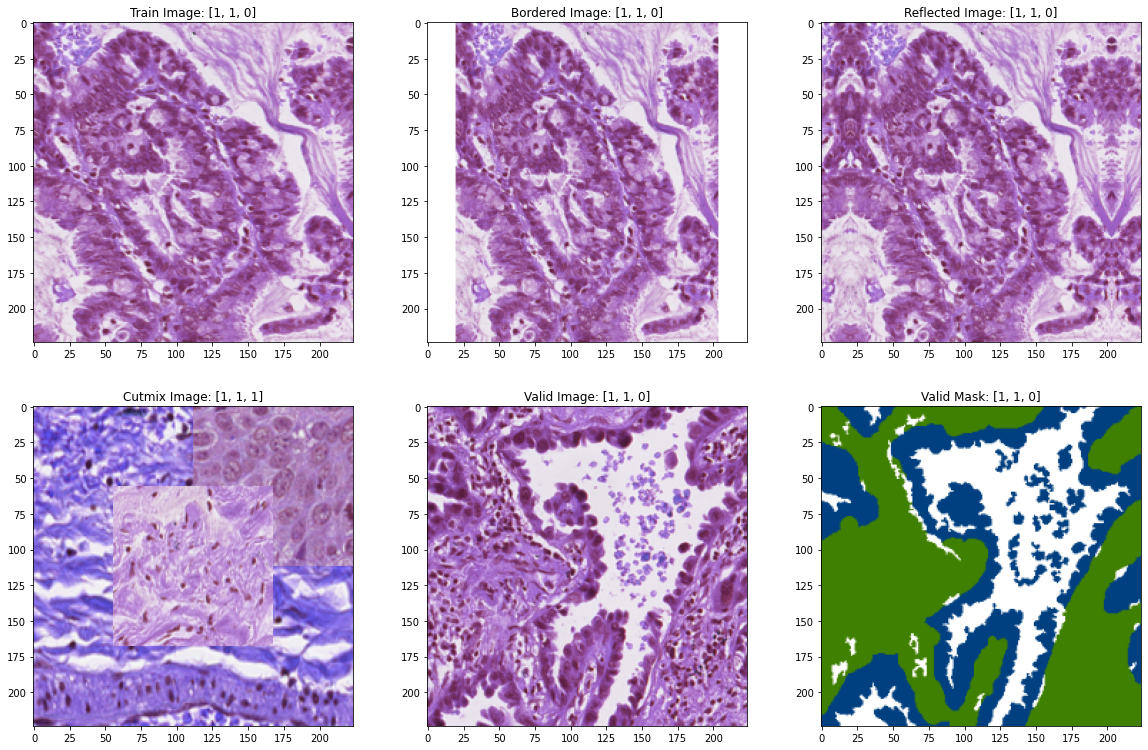

In [5]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
ax.imshow(train_image)
ax.set_title('Train Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 2)
ax.imshow(bordered_image)
ax.set_title('Bordered Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 3)
ax.imshow(reflected_image)
ax.set_title('Reflected Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 4)
ax.imshow(cutmix_image)
ax.set_title('Cutmix Image: [1, 1, 1]')

ax = fig.add_subplot(3, 3, 5)
plt.imshow(valid_img)
ax.set_title('Valid Image: [1, 1, 0]')

ax = fig.add_subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))
ax.set_title('Valid Mask: [1, 1, 0]')

In [6]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [7]:
def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [8]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if 'swin' in x and 'deit' not in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_swin_tiny_7_4_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_swin_base_7_4_224.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_swin_tiny_7_4_224.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_swin_tiny_7_4_224_01.pth']

# Model 0: model_vit_16_224_1.pth

In [46]:
model_swin_tiny_7_4_224 = timm.create_model('swin_base_patch4_window7_224', pretrained = False, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

In [47]:
model_swin_tiny_7_4_224.load_state_dict(torch.load(f=model_weights[1], map_location=device))

<All keys matched successfully>

In [48]:
%%capture
model_swin_tiny_7_4_224.eval()

In [49]:
target_layer = [model_swin_tiny_7_4_224.layers[-1].blocks[-1].norm1]
target_layer

[LayerNorm((1024,), eps=1e-05, elementwise_affine=True)]

In [50]:
train_image_tensor = preprocess_image(train_image).to(device)
bordered_image_tensor = preprocess_image(bordered_image).to(device)
reflected_image_tensor = preprocess_image(reflected_image).to(device)
cutmix_image_tensor = preprocess_image(cutmix_image).to(device)
valid_img_tensor = preprocess_image(valid_img).to(device)

## 01. GradCAM: img 0

In [51]:
cam = GradCAM(model = model_swin_tiny_7_4_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

In [52]:
valid_cam_0 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

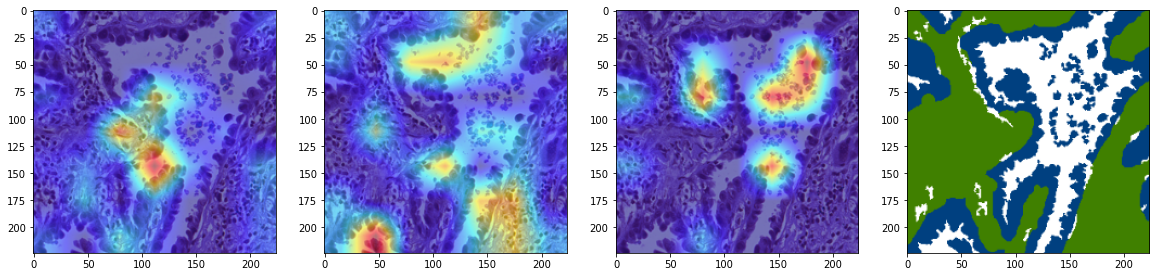

In [53]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 2)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 3)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))

ax = fig.add_subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

0.5831088423728943
0.5796252489089966


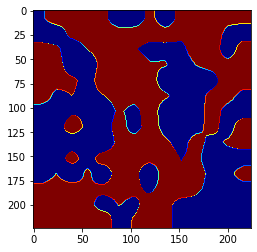

In [81]:
v = np.concatenate(l_valid_cam_0[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt = l_valid_cam_0[0, :] > t

plt.imshow(imt, cmap='jet')

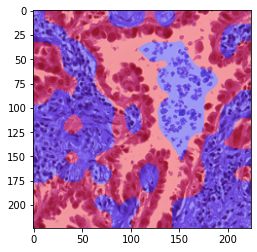

In [82]:
plt.imshow(show_cam_on_image(valid_img/255, imt, use_rgb=True))

0.20748071372509003
0.23364520072937012
0.24691647291183472
0.2532641589641571
0.25622642040252686


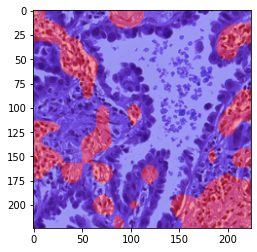

In [83]:
v = np.concatenate(l_valid_cam_1[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt = l_valid_cam_1[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(valid_img/255, imt, use_rgb=True))

## 01. Tumor

In [60]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

In [61]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [62]:
test_cam_max = np.vstack(test_cams).max(axis=0)

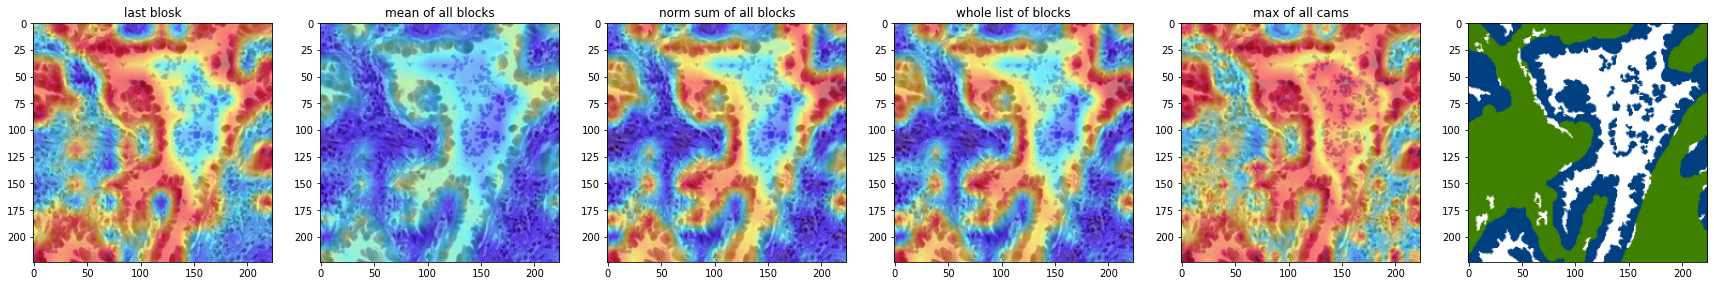

In [63]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, l_valid_cam_0[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [65]:
mean_tumor = (l_valid_cam_0 + test_cams_0) / 2

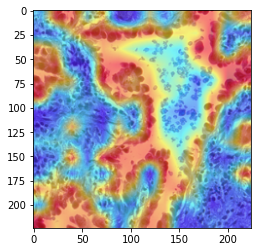

In [66]:
plt.imshow(show_cam_on_image(valid_img/255, mean_tumor[0, :], use_rgb=True))

0.5217114090919495


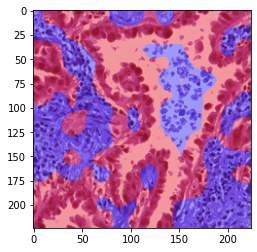

In [67]:
v = np.concatenate(mean_tumor[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt = l_valid_cam_0[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(valid_img/255, imt, use_rgb=True))

In [85]:
mean_tumor = (f_valid_cam_0 + l_valid_cam_0 + test_cams_0) / 3

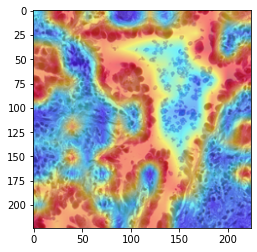

In [86]:
plt.imshow(show_cam_on_image(valid_img/255, mean_tumor[0, :], use_rgb=True))

### Class 1: Stroma

In [68]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([1]))])

In [69]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [70]:
test_cam_max = np.vstack(test_cams).max(axis=0)

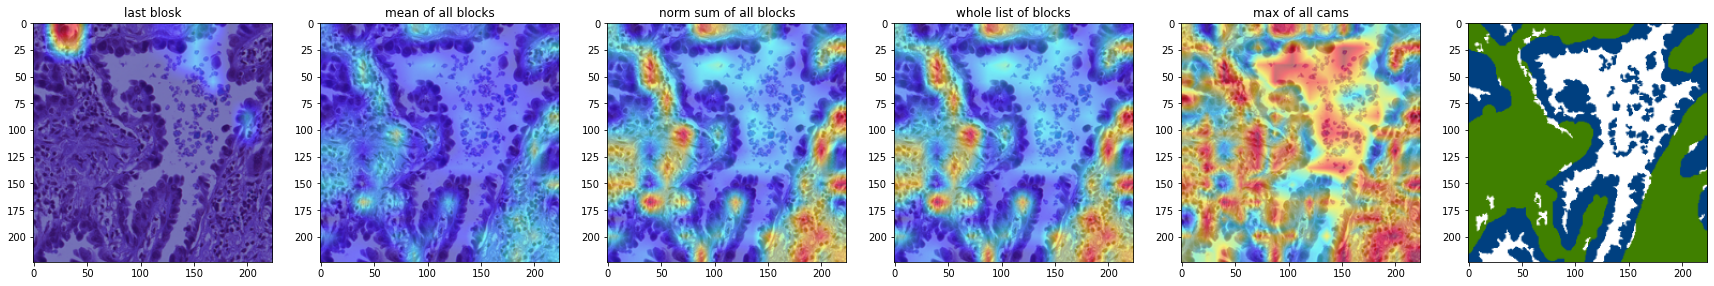

In [78]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, l_valid_cam_1[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [ ]:
mean_stroma = (valid_cam_1 + test_cams_0) / 2

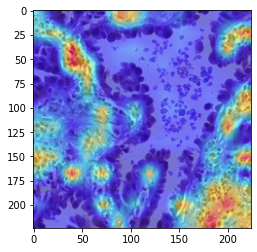

In [ ]:
plt.imshow(show_cam_on_image(valid_img/255, mean_stroma[0, :], use_rgb=True))

0.20748071372509003
0.23364520072937012
0.24691647291183472
0.2532641589641571
0.25622642040252686


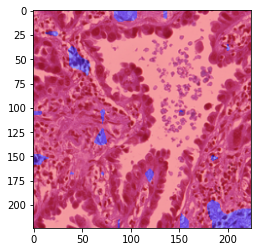

In [72]:
v = np.concatenate(l_valid_cam_1[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt_0 = l_valid_cam_1[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(valid_img/255, imt, use_rgb=True))

In [92]:
mean_stroma = (f_valid_cam_1 + l_valid_cam_1 + test_cams_0) / 3

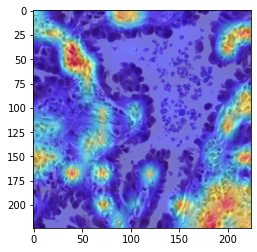

In [93]:
plt.imshow(show_cam_on_image(valid_img/255, mean_stroma[0, :], use_rgb=True))

### Class 2: Normal

In [59]:
test_cams = [x(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_img_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [60]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [61]:
test_cam_max = np.vstack(test_cams).max(axis=0)

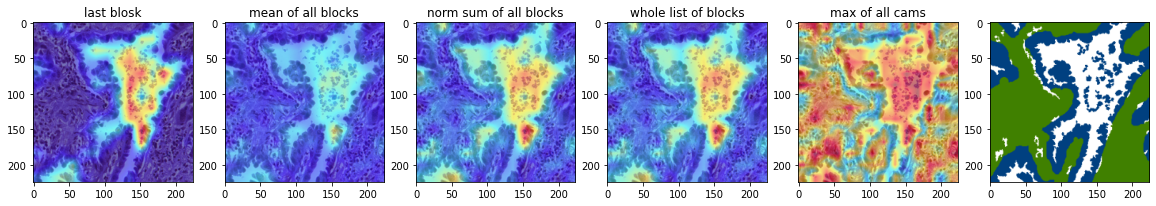

In [62]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_img/255, valid_cam_2[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_img/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_img/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_img/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [64]:
mean_normal = (valid_cam_2 + test_cams_0) / 2

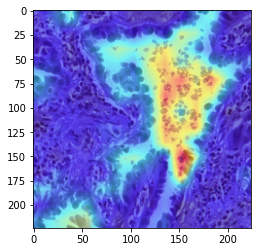

In [66]:
plt.imshow(show_cam_on_image(valid_img/255, mean_normal[0, :], use_rgb=True))

# Thresholding image to remove white background

161.23046147817146
160.13808769590264
159.58971368722513
159.04267187962418
159.04267187962418


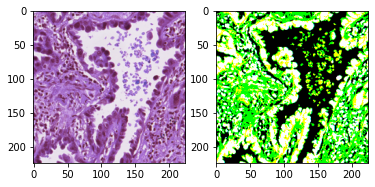

In [36]:
# thresholding the valid image to remove the background
v = np.concatenate(valid_img)
t = v.mean()
d = np.inf
ds = 0.1
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt = valid_img < t
imt = np.array(imt, dtype=np.float32)

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(imt)

In [67]:
from skimage import io, data, segmentation
from sklearn.cluster import KMeans
from skimage.color import label2rgb
from skimage import io, data, img_as_ubyte
from skimage.color import rgb2hsv, rgb2lab
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.future import graph
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank
from scipy import ndimage as ndi

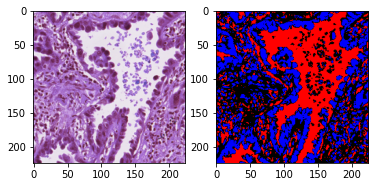

In [66]:
# Kmeans
im = np.copy(valid_img)
v = np.float32(np.column_stack([im[:,:,0].flatten(), im[:,:,1].flatten(), im[:,:,2].flatten()]))

model = KMeans(n_clusters=3, random_state=0)
labels = model.fit_predict(v)
im_labels = labels.reshape((im.shape[0], im.shape[1]))
im_labels = img_as_ubyte(color.label2rgb(im_labels))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im, cmap='jet')
plt.clim(0, 255)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(im_labels, cmap='jet')
plt.clim(0, 255)

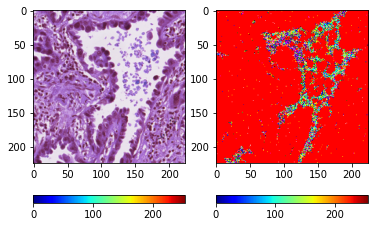

In [68]:
# DBSCAN
im = np.copy(valid_img)
v = np.float32(im.reshape((-1, 3)))

model = DBSCAN(eps=0.3, min_samples=50)
labels = model.fit_predict(v[:,:2])
im_labels = labels.reshape(im.shape[:2])
im_labels = img_as_ubyte(label2rgb(im_labels))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(im_labels, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

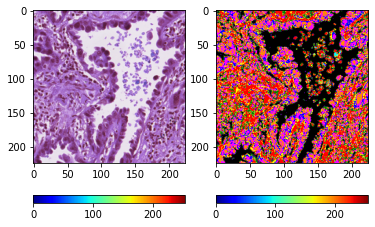

In [69]:
#mean shift
im = np.copy(valid_img)
v = np.float32(im.reshape((-1, 3)))

bandwidth = estimate_bandwidth(v, quantile=.04, n_samples=1000)
model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = model.fit_predict(v)
im_labels = labels.reshape(im.shape[:2])
im_labels = img_as_ubyte(label2rgb(im_labels))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(im_labels, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

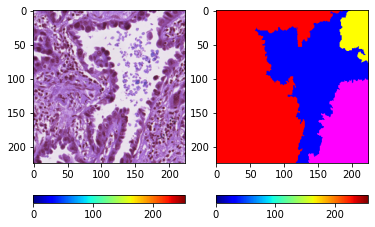

In [70]:
# Graph Cut
im = np.copy(valid_img)
im_labels_1 = segmentation.slic(im, compactness=12, n_segments=30)

g = graph.rag_mean_color(im, im_labels_1, mode='similarity')
im_labels = graph.cut_normalized(im_labels_1, g)
im_labels = img_as_ubyte(label2rgb(im_labels))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
p = plt.imshow(im, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

ax = fig.add_subplot(1, 2, 2)
p = plt.imshow(im_labels, cmap='jet')
c = plt.colorbar(orientation='horizontal')
plt.clim(0, 255)

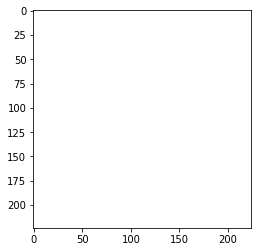

In [132]:
im = np.copy(valid_img)
#im[im > [200, 200, 200]] = 0
im[im > 159] = 0
im[im <= 159] = 255
plt.imshow(im)

In [133]:
gray = cv2.cvtColor(valid_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

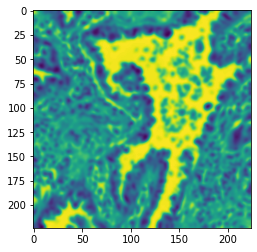

In [134]:
plt.imshow(blurred)

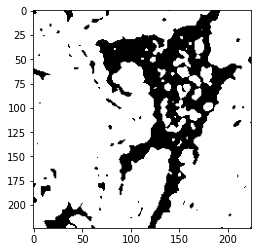

In [152]:
(T, threshInv) = cv2.threshold(blurred, 190, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv, cmap='gray')

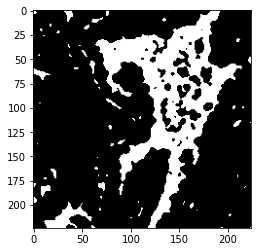

In [151]:
(T, threshInv) = cv2.threshold(blurred, 190, 255, cv2.THRESH_BINARY)
plt.imshow(threshInv, cmap='gray')

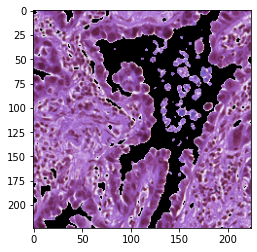

In [159]:
masked = cv2.bitwise_and(valid_img, valid_img, mask=threshInv)
plt.imshow(masked, cmap='gray')

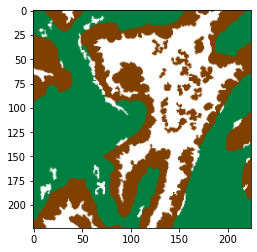

In [124]:
plt.imshow(valid_mask)

In [169]:
(T, threshInv) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

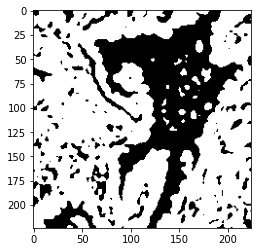

In [170]:
plt.imshow(threshInv, cmap='gray')

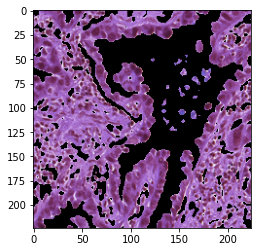

In [172]:
masked = cv2.bitwise_and(valid_img, valid_img, mask=threshInv)
plt.imshow(masked, cmap='gray')

# Checking CAMs for other images

In [62]:
f_valid_cam_0 = cam_f(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
f_valid_cam_1 = cam_f(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
f_valid_cam_2 = cam_f(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [112]:
l_valid_cam_0 = cam_l(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
l_valid_cam_1 = cam_l(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
l_valid_cam_2 = cam_l(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

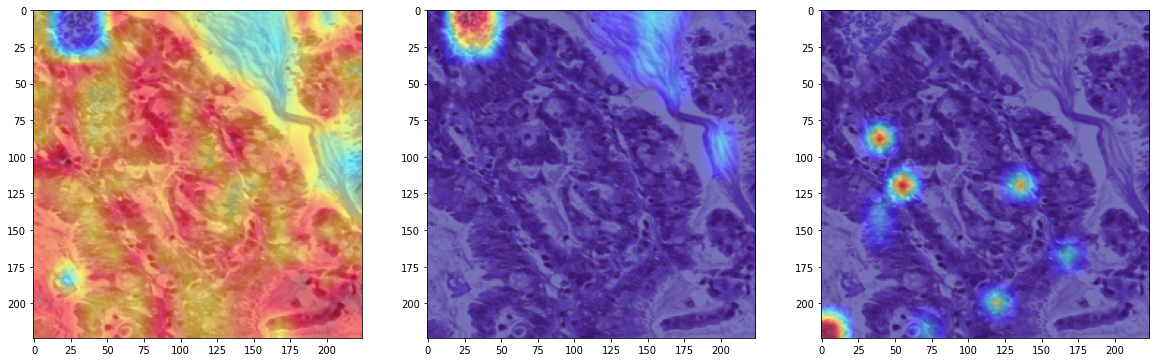

In [113]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(train_image/255, l_valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(train_image/255, l_valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(train_image/255, l_valid_cam_2[0, :], use_rgb=True))

0.6894592046737671
0.677763819694519
0.6679210066795349
0.6597909927368164
0.6529701948165894
0.6471092700958252
0.6423176527023315


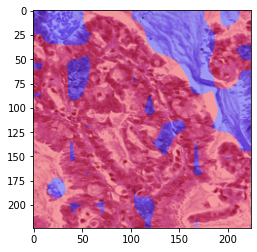

In [115]:
v = np.concatenate(l_valid_cam_0[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt_0 = l_valid_cam_0[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(train_image/255, imt_0, use_rgb=True))

0.1108778789639473
0.15248218178749084
0.1804513931274414
0.19694653153419495
0.2073911428451538
0.21531541645526886
0.2220868468284607
0.22712868452072144
0.23109832406044006


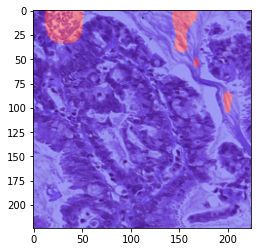

In [116]:
v = np.concatenate(l_valid_cam_1[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt_1 = l_valid_cam_1[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(train_image/255, imt_1, use_rgb=True))

0.1102098673582077
0.1524418592453003
0.17412230372428894
0.18450990319252014
0.1902037411928177
0.19288982450962067


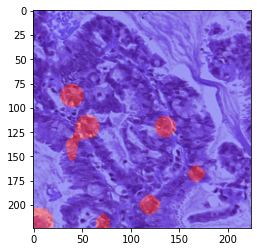

In [117]:
v = np.concatenate(l_valid_cam_2[0, :])
t = v.mean()
d = np.inf
ds = 0.005
while d > ds:
  g1 = v[v>t]
  g2 = v[v<=t]
  m1 = g1.mean()
  m2 = g2.mean()
  tp = (m1 + m2)/2
  d = np.abs(t - tp)
  t = tp
  print(t)

imt_2 = l_valid_cam_2[0, :] > t

#plt.imshow(imt, cmap='jet')

plt.imshow(show_cam_on_image(train_image/255, imt_2, use_rgb=True))

In [118]:
mask = np.zeros(train_image.shape)
mask[:, :, 0] = imt_0
mask[:, :, 1] = imt_1
mask[:, :, 2] = imt_2

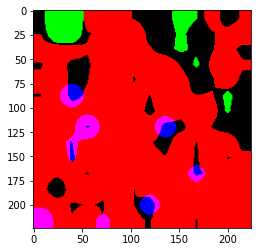

In [123]:
np.nan_to_num(mask)
plt.imshow(mask, cmap='gray')

In [132]:
cv2.imwrite('mask.png', mask*255)

True

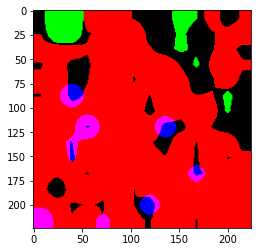

In [134]:
test = cv2.imread('mask.png')
plt.imshow(test/255)

In [142]:
np.array_equal(mask, test/255)

True

In [138]:
mask.dtype

dtype('float64')

## 01. Tumor

In [27]:
test_cams = [x(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=train_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

In [28]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [29]:
test_cam_max = np.vstack(test_cams).max(axis=0)

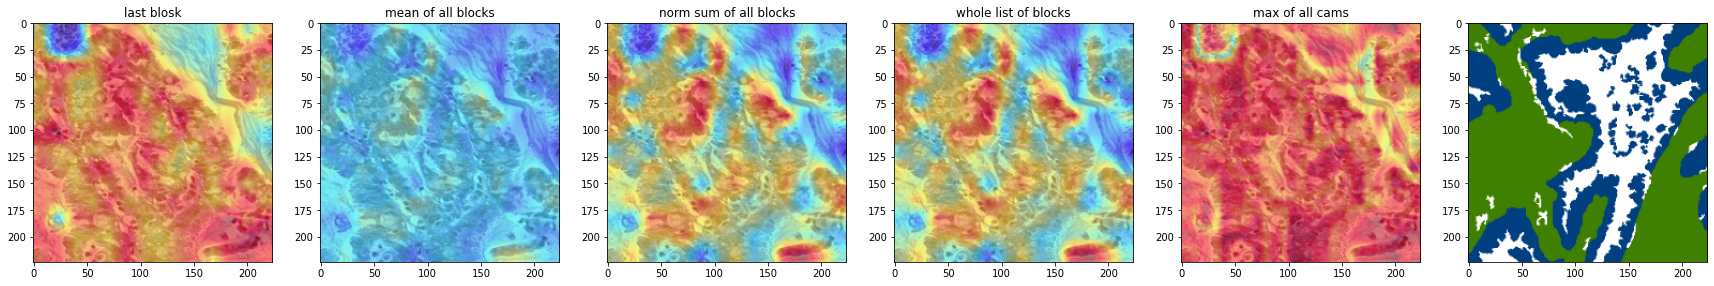

In [30]:
fig = plt.figure(figsize=(30, 15))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(train_image/255, l_valid_cam_0[0, :], use_rgb=True))     # from just the last block
ax.set_title('last blosk')

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(train_image/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks
ax.set_title('mean of all blocks')

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(train_image/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams
ax.set_title('norm sum of all blocks')

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(train_image/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers
ax.set_title('whole list of blocks')

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(train_image/255, test_cam_max, use_rgb=True))     # max of all cams
ax.set_title('max of all cams')

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

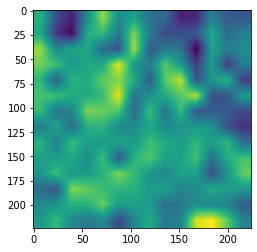

In [38]:
plt.imshow(test_cams_0[0, :])

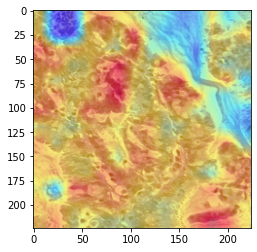

In [42]:
mean_tumor = (l_valid_cam_0 + test_cams_0) / 2
plt.imshow(show_cam_on_image(train_image/255, mean_tumor[0, :], use_rgb=True))